In [1]:
from jax import numpy as jnp, random
import phayes
import matplotlib.pyplot as plt

In [2]:
from jax.config import config
config.update("jax_enable_x64", True)

# Problem specification

In this example we won't replicate a real phase estimation experiment, instead we will assume
a known phase and simulate from the likelihood directly to try and recover it.

In [3]:
true_phi = 1.5

# Now we'll define a protocol for simulating measurements

In [4]:
def run_experiment(k: int, beta: float, n_shots: int, random_key: random.PRNGKeyArray) -> jnp.ndarray:
    k = int(k)
    p0 =  0.5 * (1 + jnp.cos(k * true_phi + beta))
    return random.choice(random_key, a=jnp.arange(2), p=jnp.array([p0, 1-p0]), shape=(n_shots,))

In [5]:
# check samples give correct likelihood
k_test = 4
beta_test = 0.43543
shots = run_experiment(k_test, beta_test, 10000, random.PRNGKey(0))
jnp.isclose(1 - shots.mean(), 0.5 * (1 + jnp.cos(k_test * true_phi + beta_test)), atol=1e-2)

Array(True, dtype=bool)

# Now we can run phase estimation

Initially we can use the strategy of [O'Brien et al](https://iopscience.iop.org/article/10.1088/1367-2630/aafb8e/pdf), at each iteration we sample $\beta \sim [0, 2 \pi]$ and set $k = \lceil 1.25 / \sigma \rceil$ where $\sigma^2$ is the prior Holevo phase variance.

In [6]:
def phase_estimation_iteration_random(prior_fourier_coeffs: jnp.ndarray, n_shots: int, random_key: random.PRNGKeyArray) -> jnp.ndarray:
    beta = random.uniform(random_key, minval=0, maxval=2 * jnp.pi)
    prior_holevo_phase_variance = phayes.fourier_holevo_variance(prior_fourier_coeffs)
    k = int(jnp.maximum(jnp.ceil(1.25 / jnp.sqrt(prior_holevo_phase_variance)), 1))

    shots = run_experiment(k, beta, n_shots, random_key)

    posterior_fourier_coeffs = phayes.fourier_update(prior_fourier_coeffs, shots, k, beta)
    return beta, k, posterior_fourier_coeffs

In [7]:
n_shots_per_experiment = 1
num_experiments = 10
fourier_length = 200
random_keys = random.split(random.PRNGKey(0), num_experiments)

In [8]:
fcs_random = [jnp.zeros((2, fourier_length))]
ks_random = []
betas_random = []

In [9]:
for i in range(num_experiments):
    beta, k, new_fc = phase_estimation_iteration_random(fcs_random[i], n_shots_per_experiment, random_keys[i])
    
    print(f"Experiment {i + 1} of {num_experiments}, k={k}, beta={beta:.2f}, coeffs used: {(new_fc != 0).sum() // 2}/{new_fc[0].size}")

    fcs_random.append(new_fc)
    ks_random.append(k)
    betas_random.append(beta)

Experiment 1 of 10, k=1, beta=3.54, coeffs used: 1/200
Experiment 2 of 10, k=1, beta=1.88, coeffs used: 2/200
Experiment 3 of 10, k=2, beta=5.24, coeffs used: 4/200
Experiment 4 of 10, k=1, beta=4.90, coeffs used: 5/200
Experiment 5 of 10, k=2, beta=6.25, coeffs used: 7/200
Experiment 6 of 10, k=1, beta=2.12, coeffs used: 8/200
Experiment 7 of 10, k=2, beta=2.74, coeffs used: 10/200
Experiment 8 of 10, k=2, beta=3.46, coeffs used: 12/200
Experiment 9 of 10, k=4, beta=0.64, coeffs used: 16/200
Experiment 10 of 10, k=4, beta=6.09, coeffs used: 20/200


But we can also select $k$ and $\beta$ that minimise the expected posterior circular variance using `phayes.fourier_get_k_and_beta`. Let's try that now using exactly the same setup as above and compare

In [10]:
def phase_estimation_iteration_deterministic(prior_fourier_coeffs: jnp.ndarray, n_shots: int, random_key: random.PRNGKeyArray) -> jnp.ndarray:
    k, beta = phayes.fourier_get_k_and_beta(prior_fourier_coeffs)

    shots = run_experiment(k, beta, n_shots, random_key)

    posterior_fourier_coeffs = phayes.fourier_update(prior_fourier_coeffs, shots, k, beta)
    return beta, k, posterior_fourier_coeffs

In [11]:
fcs_deterministic = [jnp.zeros((2, fourier_length))]
ks_deterministic = []
betas_deterministic = []

In [12]:
for i in range(num_experiments):
    beta, k, new_fc = phase_estimation_iteration_deterministic(fcs_deterministic[i], n_shots_per_experiment, random_keys[i])
    
    print(f"Experiment {i + 1} of {num_experiments}, k={k}, beta={beta:.2f}, coeffs used: {(new_fc != 0).sum() // 2}/{new_fc[0].size}")

    fcs_deterministic.append(new_fc)
    ks_deterministic.append(k)
    betas_deterministic.append(beta)

Experiment 1 of 10, k=1, beta=1.57, coeffs used: 1/200
Experiment 2 of 10, k=1, beta=3.14, coeffs used: 2/200
Experiment 3 of 10, k=1, beta=0.89, coeffs used: 3/200
Experiment 4 of 10, k=2, beta=2.21, coeffs used: 5/200
Experiment 5 of 10, k=2, beta=1.66, coeffs used: 7/200
Experiment 6 of 10, k=3, beta=2.13, coeffs used: 10/200
Experiment 7 of 10, k=4, beta=1.37, coeffs used: 14/200
Experiment 8 of 10, k=1, beta=1.53, coeffs used: 15/200
Experiment 9 of 10, k=5, beta=0.91, coeffs used: 20/200
Experiment 10 of 10, k=7, beta=3.13, coeffs used: 27/200


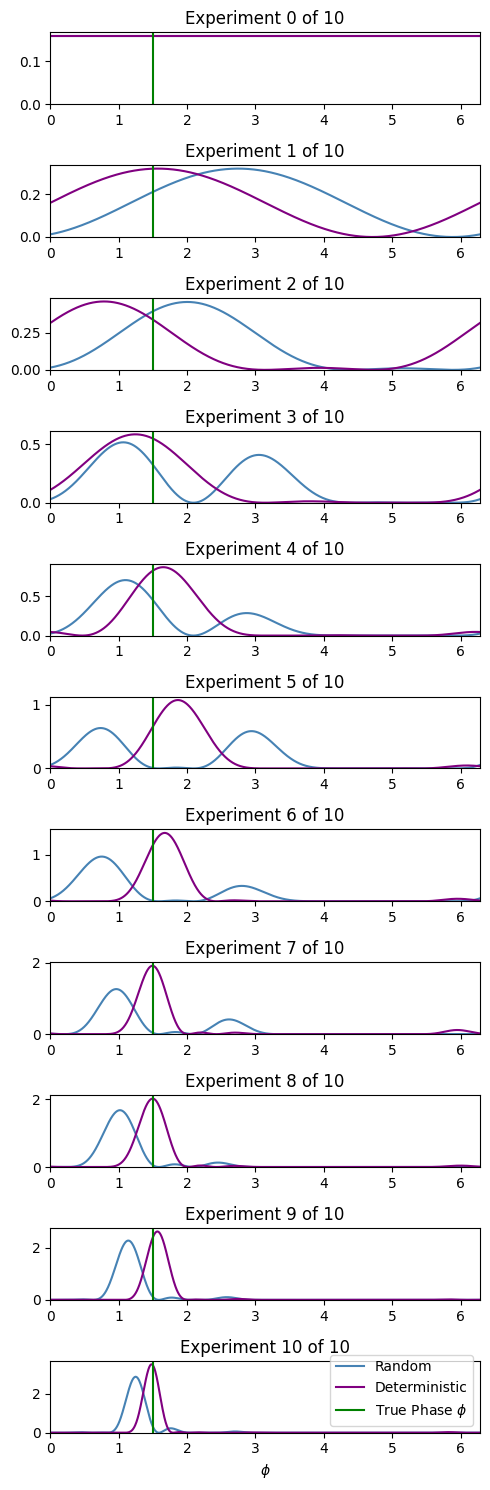

In [13]:
pdf_linsp = jnp.linspace(0, 2 * jnp.pi, 1000)

fig, axes = plt.subplots(num_experiments + 1, figsize=(5, 15))
for i in range(num_experiments + 1):
    axes[i].plot(pdf_linsp,phayes.fourier_pdf(pdf_linsp, fcs_random[i]), c='steelblue', label='Random')
    axes[i].plot(pdf_linsp,phayes.fourier_pdf(pdf_linsp, fcs_deterministic[i]), c='purple', label='Deterministic')
    axes[i].axvline(true_phi, color='green', label=r'True Phase $\phi$')
    axes[i].set_title(f"Experiment {i} of {num_experiments}")
    axes[i].set_xlim(0, 2 * jnp.pi)
    axes[i].set_ylim(0, axes[i].get_ylim()[1])
    
axes[-1].set_xlabel(r'$\phi$')
axes[-1].legend()
fig.tight_layout()